# Задание 3 — численное решение интегрального уравнения Фредгольма второго рода

In [1]:
import numpy as np
from numpy.typing import NDArray
from scipy.integrate import quad
from scipy.optimize import fmin
from functools import cache
from typing import Callable, Literal
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import Latex, Markdown, display
import warnings
warnings.filterwarnings('ignore')

In [2]:
def latexify(arr: NDArray) -> str:
    res = []
    res.append('\\begin{pmatrix}')
    if len(arr.shape) == 1:
        for i in range(arr.size):
            res.append(f"{arr[i]:.4f}")
            if i != arr.size - 1:
                res.append("\\\\")
    elif len(arr.shape) == 2:
        for i in range(arr.shape[0]):
            for j in range(arr.shape[1]):
                res.append(f"{arr[i][j]:.4f}")
                if j != arr.shape[1] - 1:
                    res.append("&")
            if i != arr.shape[0] - 1:
                res.append("\\\\")
    res.append('\\end{pmatrix}')
    return ' '.join(res)

def print_tex(*argv) -> None:
    """Displays a LaTeX Markdown output"""
    res = ' '.join(['$$'] + [(latexify(arg) if isinstance(arg,
                   np.ndarray) else str(arg)) for arg in argv] + ['$$'])
    display(Markdown(res))

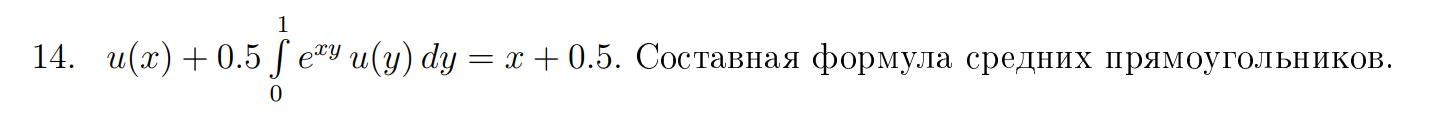

In [3]:
H = lambda x, y: np.exp(x * y)
f = lambda x: x + .5

a, b = 0, 1

## Метод замены ядра на вырожденное

In [4]:
def taylor(k):
    return lambda x: x**k / np.sqrt(np.math.factorial(k))

alpha = [taylor(k) for k in range(4)]
beta = [taylor(k) for k in range(4)]

H_3 = lambda x, y: np.sum([alpha[i](x) * beta[i](y) for i in range(3)])
H_4 = lambda x, y: np.sum([alpha[i](x) * beta[i](y) for i in range(4)])

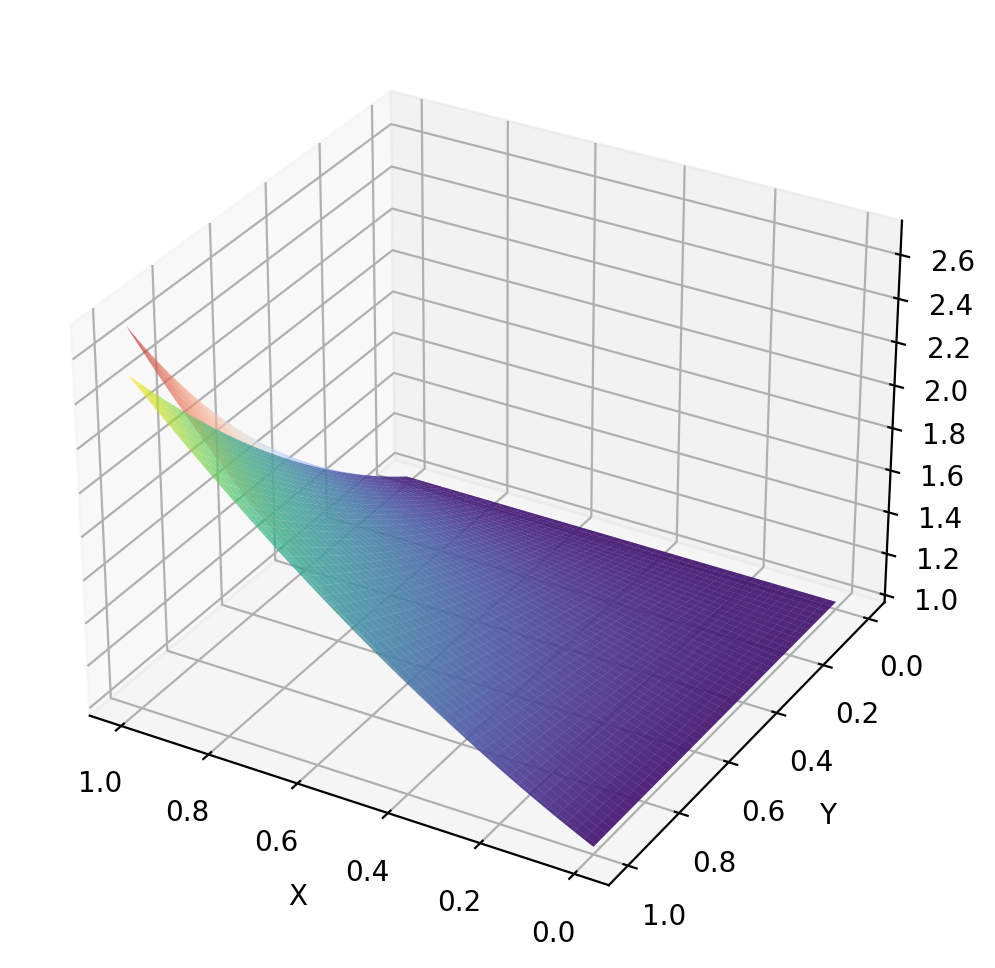

In [5]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 6), dpi=200)

X = np.linspace(a, b, 100)
Y = np.linspace(a, b, 100)
X, Y = np.meshgrid(X, Y)
Z_1 = np.exp(X * Y)
Z_2 = taylor(0)(X) * taylor(0)(Y) + taylor(1)(X) * taylor(1)(Y) + taylor(2)(X) * taylor(2)(Y)

surf = ax.plot_surface(X, Y, Z_1, cmap=cm.coolwarm, linewidth=0, antialiased=True, alpha=0.7)
surf = ax.plot_surface(X, Y, Z_2, cmap=cm.viridis, linewidth=0, antialiased=True, alpha=0.7)
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [6]:
def B(k: Literal[3, 4]) -> NDArray:
    res = np.zeros(k)
    for i in range(k):
        res[i], _ = quad(lambda x: beta[i](x) * f(x), a, b)
    return res

def G(k: Literal[3, 4]) -> NDArray:
    res = np.zeros((k, k))
    for i in range(k):
        for j in range(k):
            res[i][j], _ = quad(lambda x: beta[i](x) * alpha[j](x), a, b)
    return res

def A(k: Literal[3, 4]) -> NDArray:
    G_ = G(k)
    res = np.zeros((k, k))
    for i in range(k):
        for j in range(k):
            res[i][j] = (i == j) - G_[i][j]
    return res

def C(k: Literal[3, 4]) -> NDArray:
    return np.linalg.solve(A(k), B(k))

print_tex(r"A_3 = ", A(3), r",~B_3 = ", B(3), r",~C_3 = ", C(3))
print_tex(r"A_4 = ", A(4), r",~B_4 = ", B(4), r",~C_4 = ", C(4))


$$ A_3 =  \begin{pmatrix} 0.0000 & -0.5000 & -0.2357 \\ -0.5000 & 0.6667 & -0.1768 \\ -0.2357 & -0.1768 & 0.9000 \end{pmatrix} ,~B_3 =  \begin{pmatrix} 1.0000 \\ 0.5833 \\ 0.2946 \end{pmatrix} ,~C_3 =  \begin{pmatrix} -3.0553 \\ -1.6265 \\ -0.7923 \end{pmatrix} $$

$$ A_4 =  \begin{pmatrix} 0.0000 & -0.5000 & -0.2357 & -0.1021 \\ -0.5000 & 0.6667 & -0.1768 & -0.0816 \\ -0.2357 & -0.1768 & 0.9000 & -0.0481 \\ -0.1021 & -0.0816 & -0.0481 & 0.9762 \end{pmatrix} ,~B_4 =  \begin{pmatrix} 1.0000 \\ 0.5833 \\ 0.2946 \\ 0.1327 \end{pmatrix} ,~C_4 =  \begin{pmatrix} -2.9322 \\ -1.5691 \\ -0.7669 \\ -0.3397 \end{pmatrix} $$

In [7]:
def U(k: Literal[3, 4]) -> Callable:
    C_ = C(k)
    return lambda x: f(x) + sum([C_[i] * alpha[i](x) for i in range(k)])

u_3 = U(3)
u_4 = U(4)

pts = [0, 0.5, 1]

print_tex("\Delta = ", np.max([
    abs(u_3(p) - u_4(p)) for p in pts
]))

pd.DataFrame({
    "U3" : {
        "0": u_3(0),
        "0.5": u_3(.5),
        "1": u_3(1)
    },
    "U4" : {
        "0": u_4(0),
        "0.5": u_4(.5),
        "1": u_4(1)
    }
})

$$ \Delta =  0.13888256907998198 $$

,U3,U4
0,-2.555259,-2.432218
0.5,-3.008575,-2.869692
1,-3.741997,-3.682324


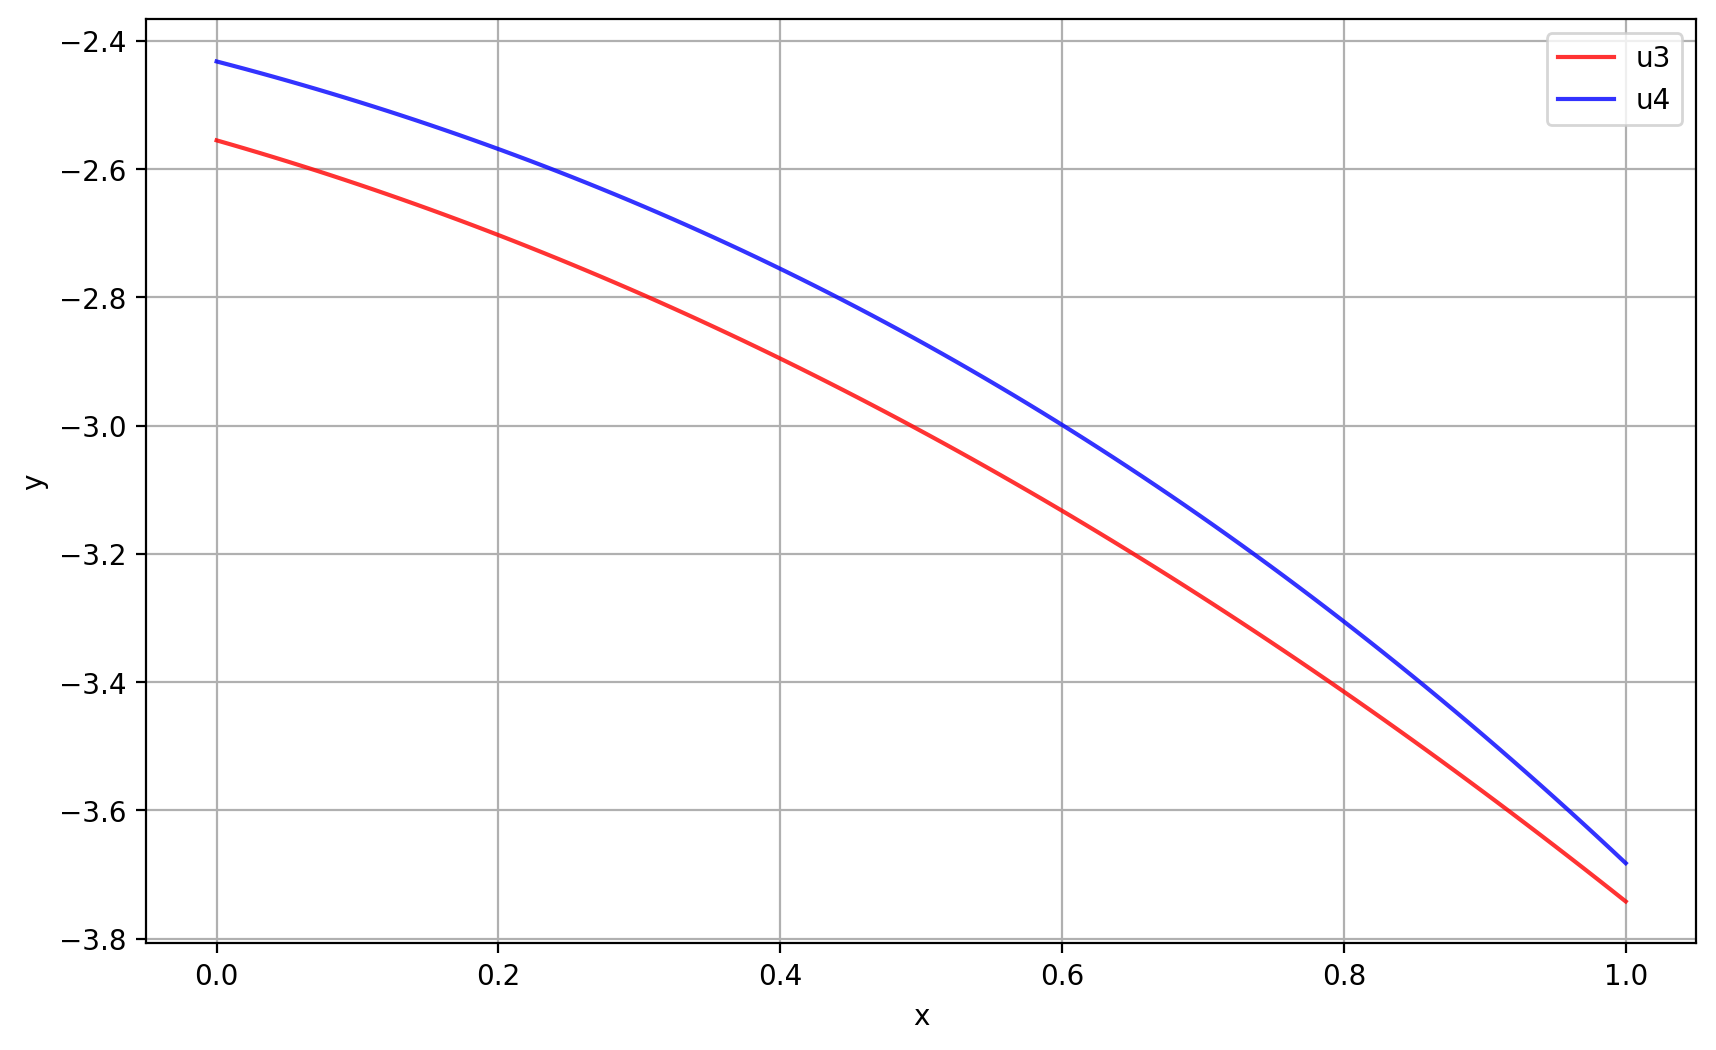

In [8]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
x = np.linspace(a, b, 100)
plt.plot(x, u_3(x), color="red", label=r"u3", alpha=0.8)
plt.plot(x, u_4(x), color="blue", label=r"u4", alpha=0.8)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
ax.grid()
plt.show()

In [9]:
norm = lambda x: -abs(u_3(x) - u_4(x)) if a <= x <= 1 else 0
fmin(norm, 0)

Optimization terminated successfully.
         Current function value: -0.140034
         Iterations: 22
         Function evaluations: 44


array([0.417])

In [17]:
def D(k: Literal[3, 4]) -> NDArray:
    return np.linalg.inv(A(k))

def Res(x, y, k=3):
    s = 0
    D_ = D(k)
    for i in range(k):
        for j in range(k):
            s += D_[i][j] * alpha[i](x) * beta[j](y)
    return s

IRes = lambda x: abs(quad(lambda y: Res(x, y), a, b)[0])

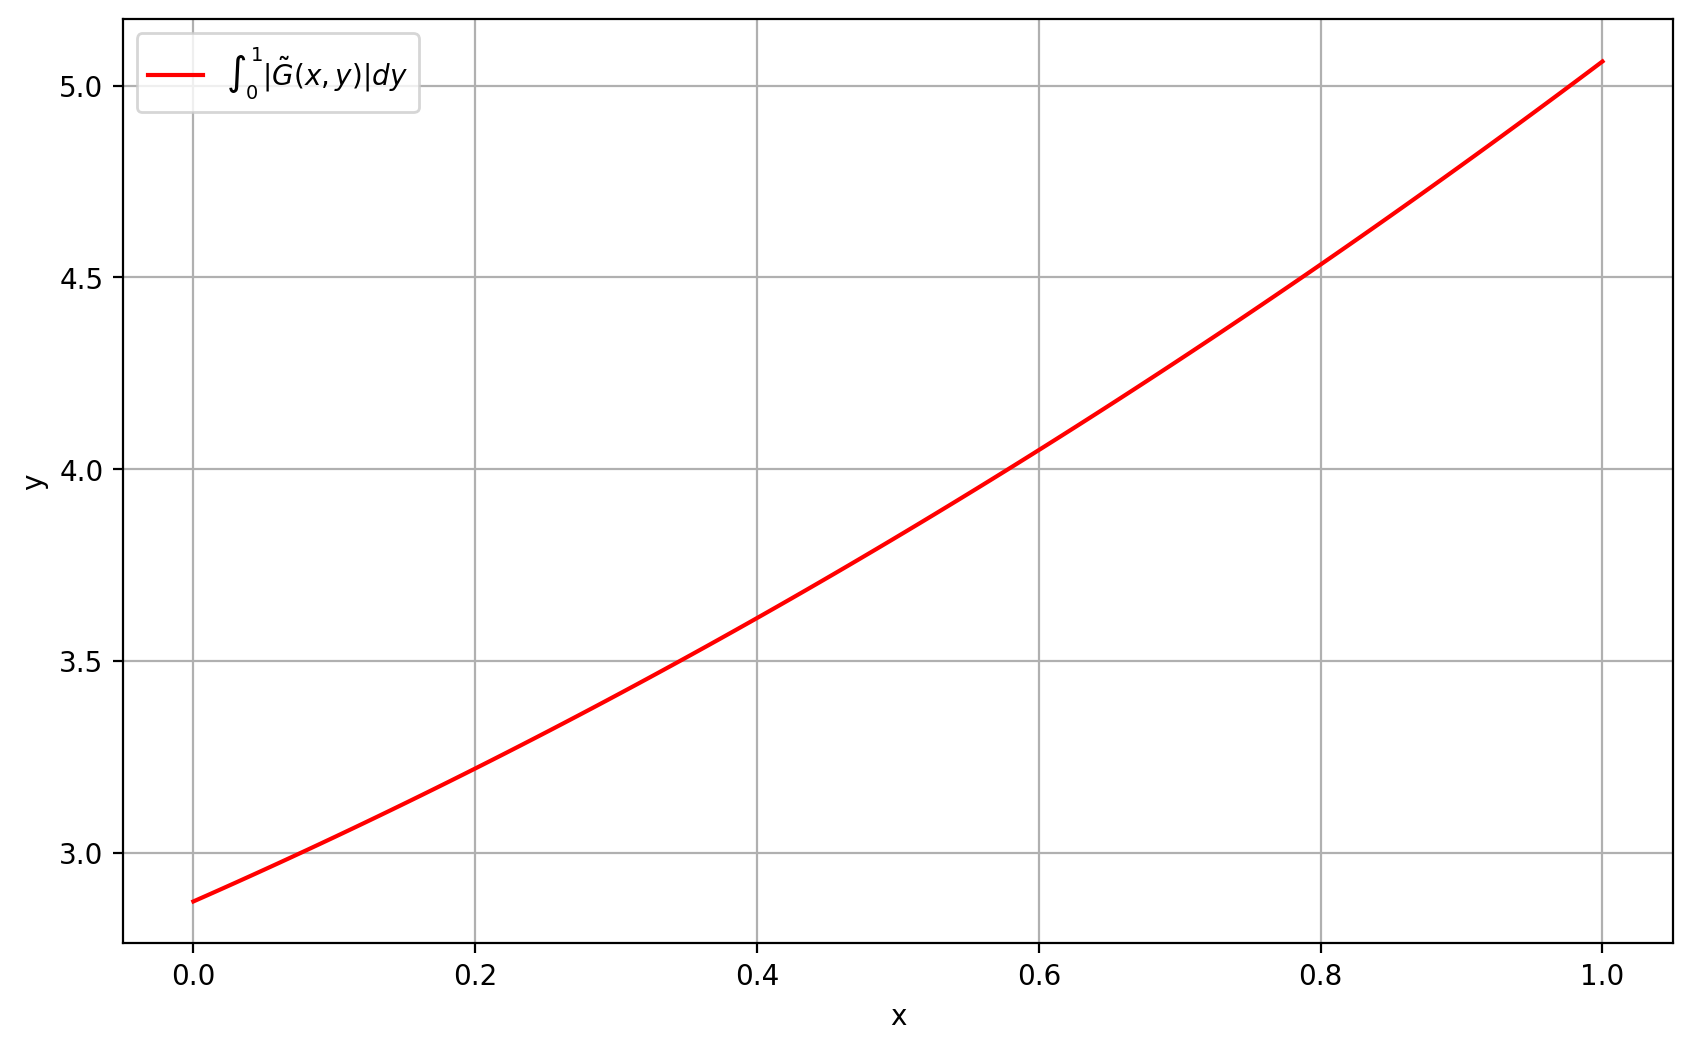

In [37]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
x = np.linspace(a, b, 100)
plt.plot(x, [IRes(p) for p in x], color="red", label=r"$\int_0^1|\tilde G(x, y)|dy$")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
ax.grid()
plt.show()

In [21]:
M = IRes(b)
print_tex(r"\tilde B =", M)

$$ \tilde B = 5.0632621951219505 $$

In [22]:
def Ker(x, y):
    return abs(H(x, y) - H_3(x, y))

IKer = lambda x: quad(lambda y: Ker(x, y), a, b)[0]

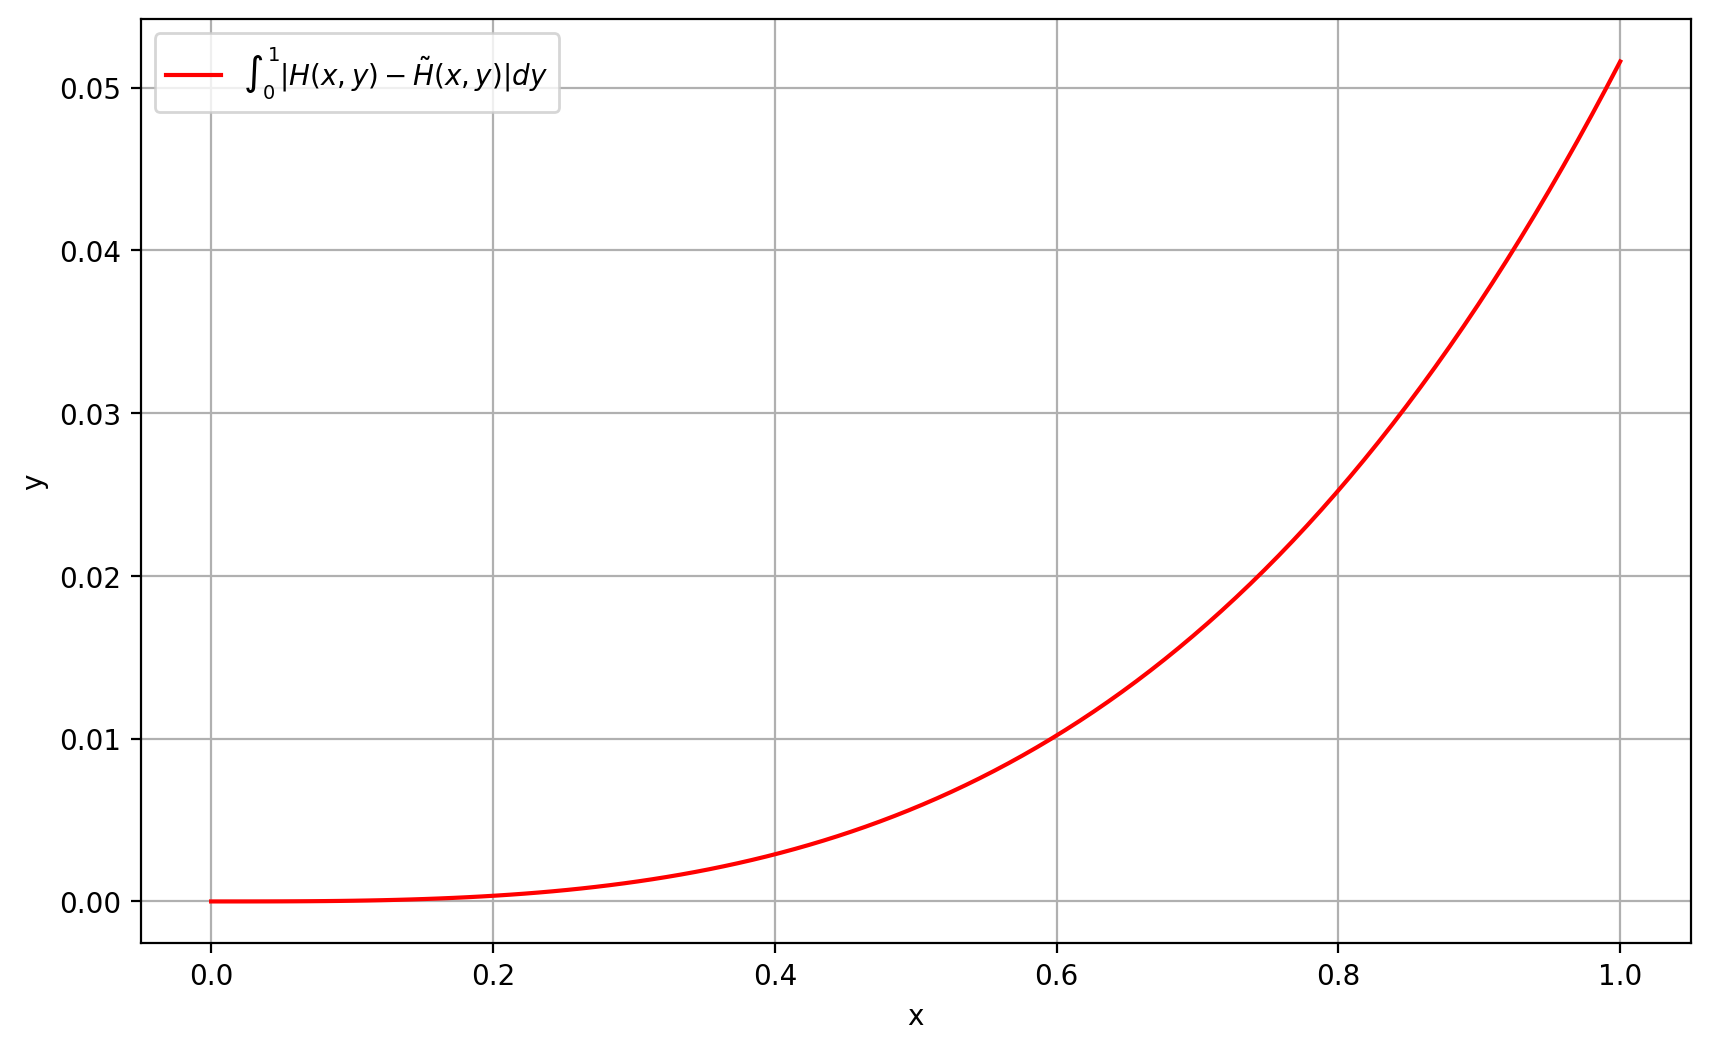

In [38]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
x = np.linspace(a, b, 100)
plt.plot(x, [IKer(p) for p in x], color="red", label=r"$\int_0^1|H(x,y) - \tilde H(x, y)|dy$")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
ax.grid()
plt.show()

In [27]:
eta = IKer(b)
print_tex(r"\eta =", eta)

$$ \eta = 0.05161516179237863 $$

In [33]:
print_tex(r"\frac{|u^*(x) - \tilde u^n(x)|}{|| \tilde u^*(x) ||_C} \le", (1 + M) * eta / (1 - (1 + M) * eta))

$$ \frac{|u^*(x) - \tilde u^n(x)|}{|| \tilde u^*(x) ||_C} \le 0.45551140429901466 $$

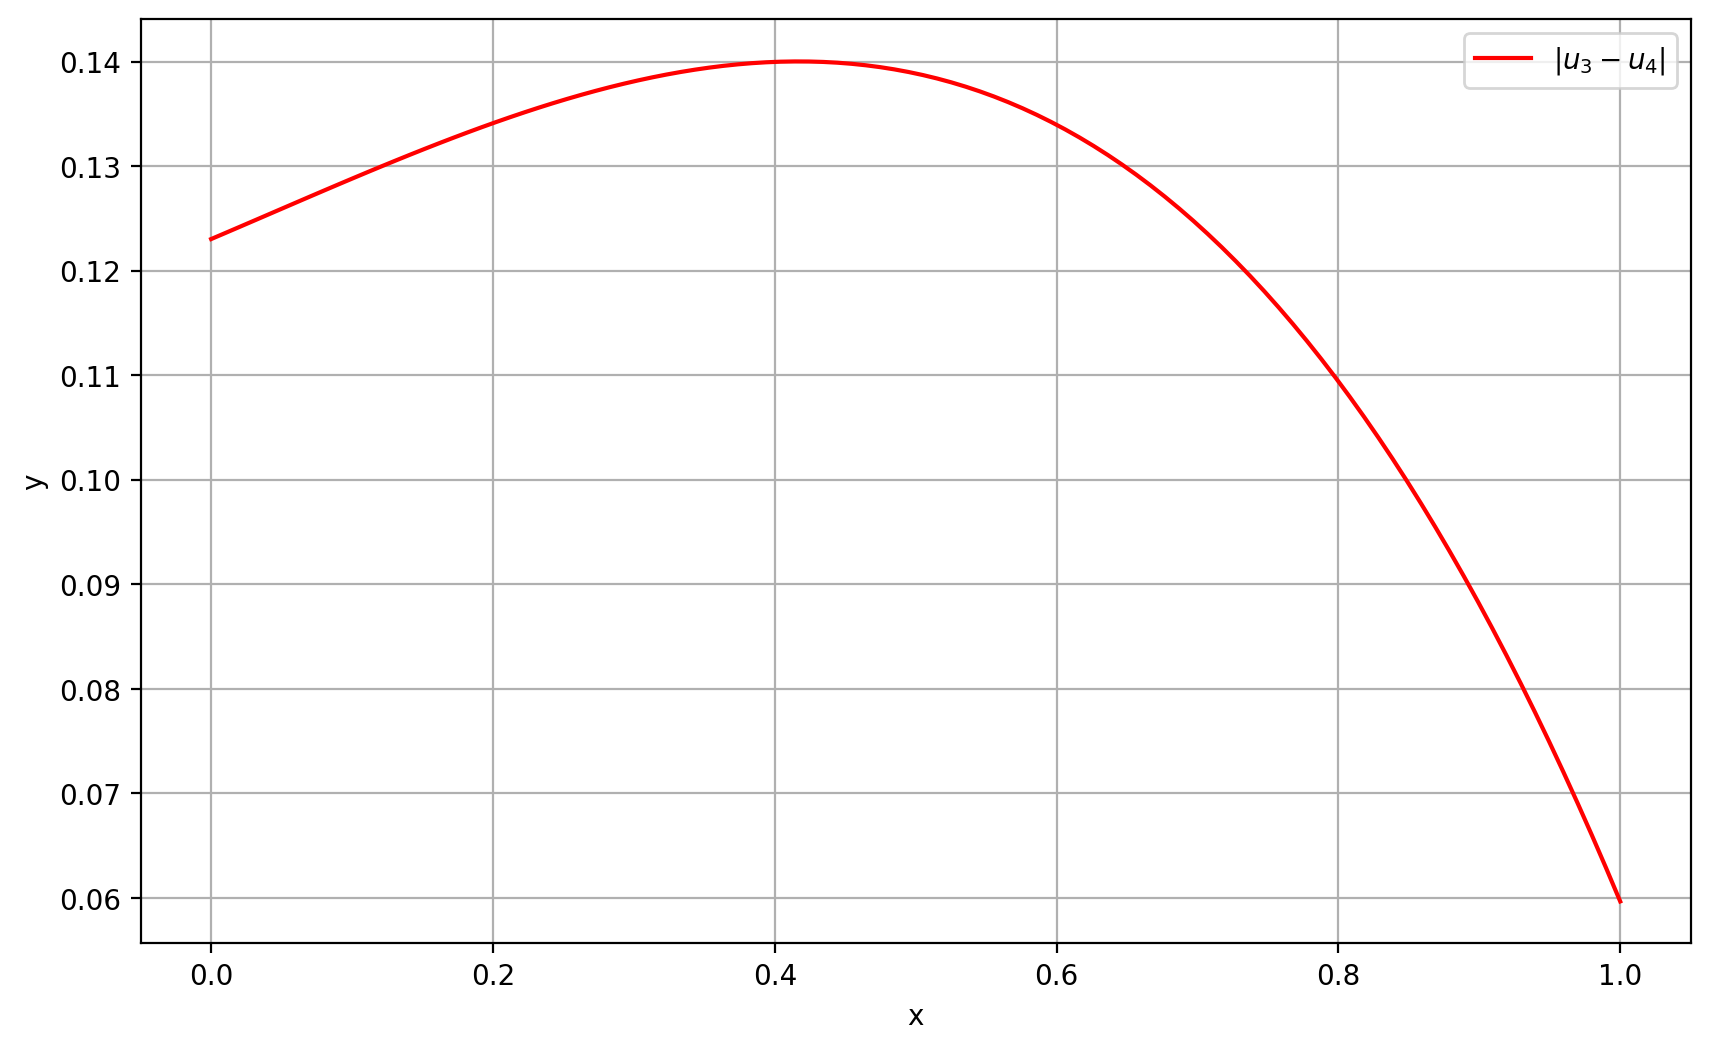

In [39]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
x = np.linspace(a, b, 100)
plt.plot(x, np.abs(u_3(x) - u_4(x)), color="red", label=r"$|u_3 - u_4|$")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid()
ax.legend()
plt.show()

## Метод механических квадратур

In [64]:
n = 200
eps = 1.e-8

def target(u: Callable) -> float:
    return abs(max([u(a), u((a + b) / 2), u(b)]))

var = 1.e+8
u_n = u_3

while var > eps:
    n *= 2
    h = (b - a) / (n + 1)
    x_ = np.linspace(a + h, b - h, n)

    D = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            D[i][j] = (i == j) - h * H(x_[i], x_[j])

    g = f(x_)
    z = np.linalg.solve(D, g)
    t_prev = target(u_n)

    def sol(x):
        s = f(x)
        for i in range(n):
            s += h * H(x, x_[i]) * z[i]
        return s
    
    u_n = sol
    t_next = target(u_n)
    var = abs(t_prev - t_next)

n

800

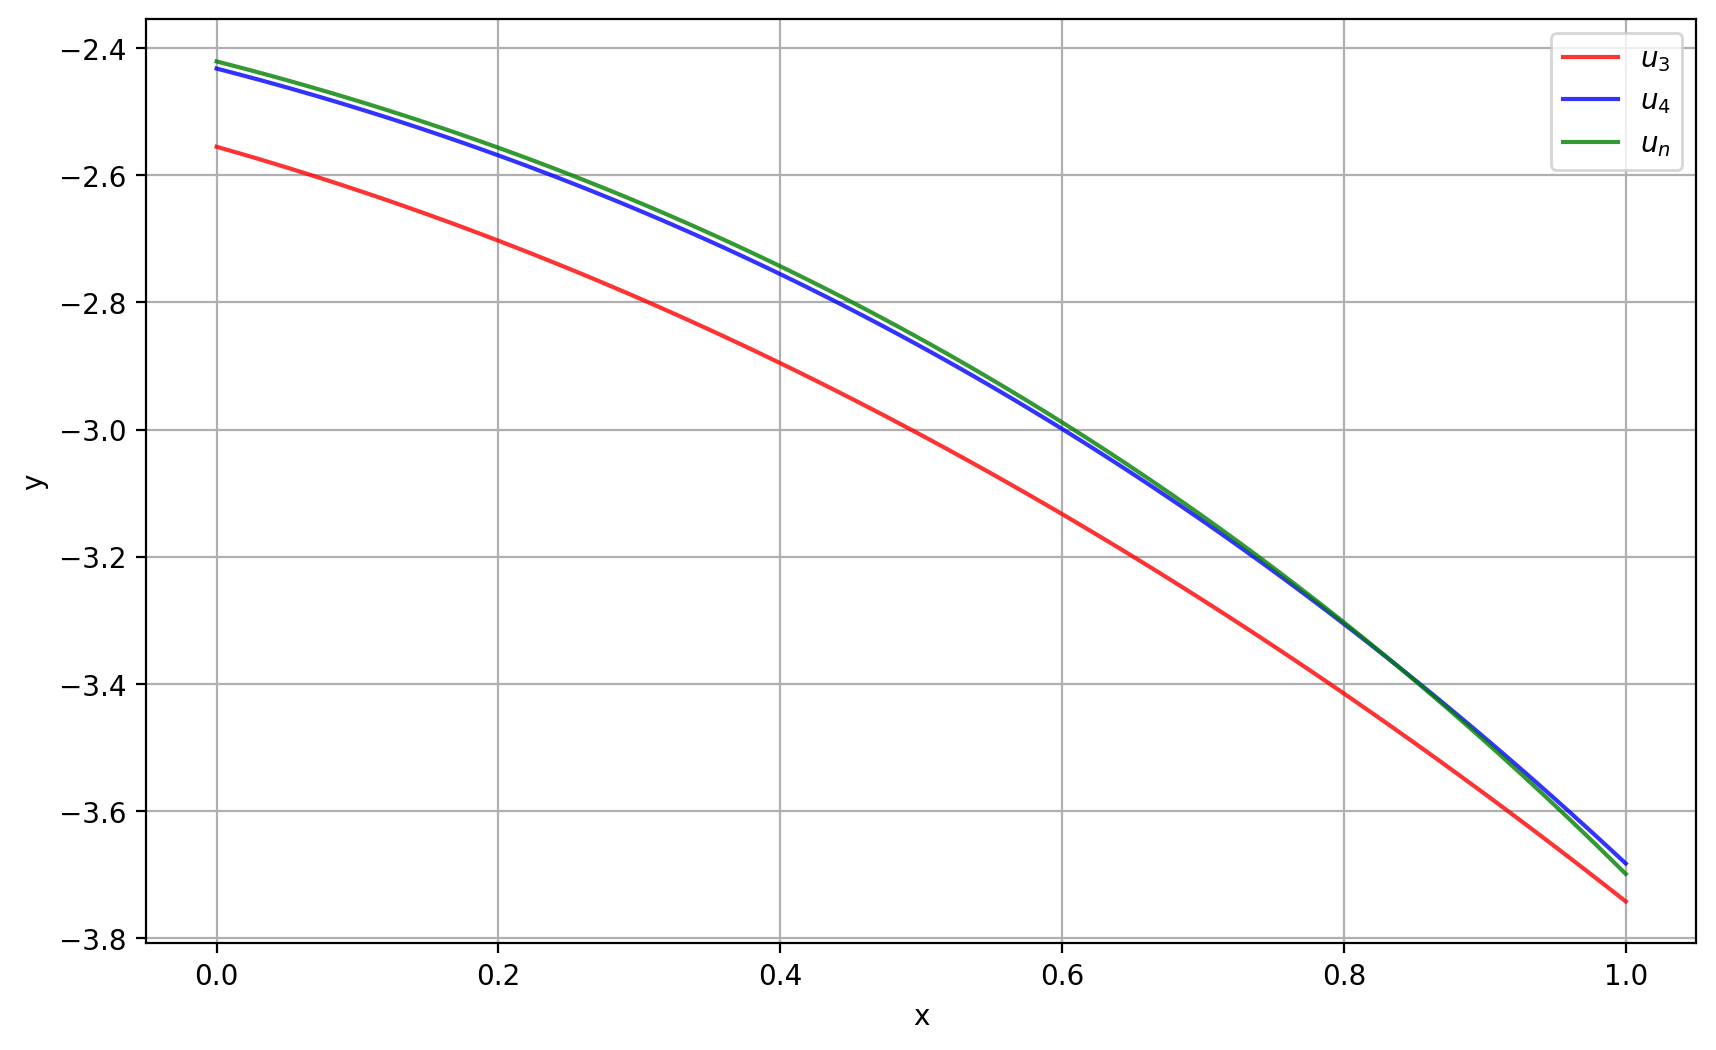

In [65]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
x = np.linspace(a, b, 100)
plt.plot(x, u_3(x), color="red", label=r"$u_3$", alpha=0.8)
plt.plot(x, u_4(x), color="blue", label=r"$u_4$", alpha=0.8)
plt.plot(x, u_n(x), color="green", label=r"$u_n$", alpha=0.8)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
ax.grid()
plt.show()